# **INFERENCES**

The different models developed, tried and submitted are implemented in this notebook.
___
___

## **INITIALIZATION**

### *IMPORTS*

First we import all the libraries needed to use the data and create our models:

In [8]:
from IPython.display import display # to display dataframes

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns # to provide plots

from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

import torch
import torch.nn.functional as F
import torch.utils.data as data_utils
import torchvision.utils as vutils

To create the ```requirement.txt``` file we need the followign line of code:

In [9]:
import session_info
session_info.show()

### *DATA LOADING*

The data from the ```train.csv``` file is loaded into a pandas dataframe:

In [5]:
train_df = pd.read_csv("train.csv", index_col=0, names=["val1", "val2", "val3", "val4"])
display(train_df)

,val1,val2,val3,val4
0,0.012495,0.011126,0.003252,0.006625
1,0.011439,0.002691,0.001206,0.006947
2,0.000632,0.007277,0.004049,0.000074
3,0.017828,0.028210,0.007758,0.007382
4,0.021115,0.019642,0.009238,0.011499
...,...,...,...,...
741,0.001938,0.008833,0.003927,0.005106
742,0.005003,0.018943,0.003057,0.001988
743,0.007683,0.001958,0.007002,0.006467
744,0.003396,0.001280,0.007621,0.001680


___

## **DATA PREPROCESSING**

### *DATA NORMALIZATION*

In [36]:
train_df_normalized = (train_df-train_df.mean())/train_df.std()

### *DATA VISUALIZATION*

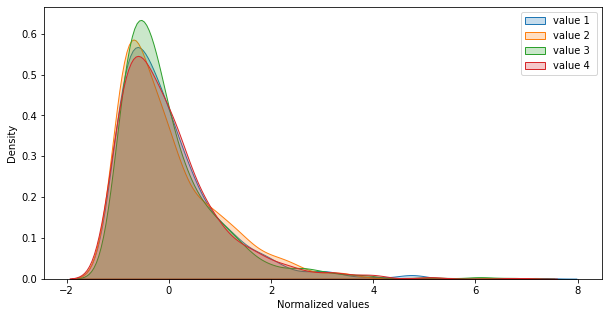

In [37]:
plt.figure(figsize=(10,5))
for column in train_df_normalized.columns:
    sns.kdeplot(train_df_normalized[column], shade=True)
plt.xlabel("Normalized values")
plt.legend(labels=["value 1", "value 2 ", "value 3", "value 4"])
plt.show()

___

## **Basic GAN**

Based on this [GitHub tutorial](https://github.com/tomsercu/gan-tutorial-pytorch/blob/master/2019-04-23%20GAN%20Tutorial.ipynb).

### *DEFINING THE NEURAL NETWORKS*

In [38]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device: {}".format(device))

device: cuda


In [39]:
class Disciminator(nn.Module):

    def __init__(self, input_size=4):
        super(Disciminator, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.nl1 = nn.LeakyReLU(0.25)
        self.fc2 = nn.Linear(32, 16)
        self.nl2 = nn.LeakyReLU(0.125)
        self.fc3 = nn.Linear(16, 8)
        self.nl3 = nn.LeakyReLU(0.125)
        self.fc4 = nn.Linear(8, 1)
    
    def forward(self, x):
        o = self.nl1(self.fc1(x))
        o = self.nl2(self.fc2(o))
        o = self.nl3(self.fc3(o))
        return torch.sigmoid(self.fc4(o))

In [43]:
class Generator(nn.Module):

    def __init__(self, z_size=100):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_size, 128)
        self.nl1 = nn.LeakyReLU(0.25)
        self.fc2 = nn.Linear(128, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.nl2 = nn.LeakyReLU(0.125)
        self.fc3 = nn.Linear(32, 4)
    
    def forward(self, x):
        o = self.nl1(self.fc1(x))
        o = self.nl2(self.bn2(self.fc2(o)))
        return self.fc3(o)
        

In [44]:
D = Disciminator().to(device)
print(D)

G = Generator().to(device)
print(G)

Disciminator(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (nl1): LeakyReLU(negative_slope=0.25)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (nl2): LeakyReLU(negative_slope=0.125)
  (fc3): Linear(in_features=16, out_features=8, bias=True)
  (nl3): LeakyReLU(negative_slope=0.125)
  (fc4): Linear(in_features=8, out_features=1, bias=True)
)
Generator(
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (nl1): LeakyReLU(negative_slope=0.25)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (nl2): LeakyReLU(negative_slope=0.125)
  (fc3): Linear(in_features=32, out_features=4, bias=True)
)


### *TESTING THE NEURAL NETWORKS*

In [45]:
samples = torch.randn(5, 4).to(device)
D(samples)

tensor([[0.5011],
        [0.5027],
        [0.4881],
        [0.5015],
        [0.5044]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [46]:
z_samples = torch.randn(5, 100).to(device)
G(z_samples)

tensor([[ 5.4217e-04, -3.3940e-02, -1.0350e-02, -5.8724e-01],
        [ 1.9577e-01, -1.0289e+00, -4.4823e-01, -6.5199e-01],
        [ 7.0085e-01, -8.1915e-01,  7.0840e-01, -4.1954e-01],
        [-5.2547e-02,  2.6493e-01,  2.9165e-01,  6.8401e-02],
        [ 3.7801e-01,  7.2028e-02, -5.9825e-01, -8.4818e-02]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

### *DATASET LOADING*

In [47]:
batch_size = 64

features = torch.tensor(train_df_normalized.values).to(device)
true_targets = torch.ones((features.shape[0],1)).to(device)
fake_targets = torch.zeros((features.shape[0],1)).to(device)

train_ds = data_utils.TensorDataset(features, true_targets)
train_ds_loader = data_utils.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

### *TRAINING THE NETWORKS*

In [48]:
optimizerD = optim.SGD(D.parameters(), lr=0.05)
optimizerG = optim.SGD(G.parameters(), lr=0.05)

In [49]:
criterion = nn.BCELoss()
n_epochs = 10000
fixed_noise = torch.randn(batch_size, 100).to(device)
collect_x_gen = []

epoch 1 || lossD = 1.426684856414795 | lossG = 0.903160810470581


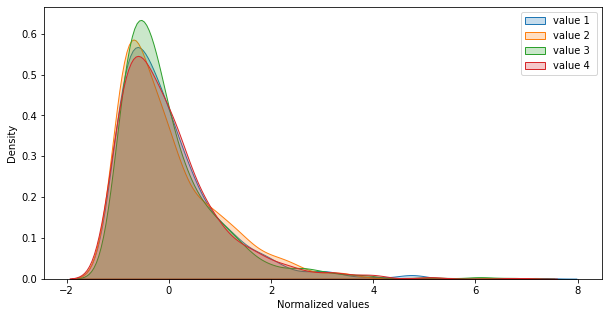

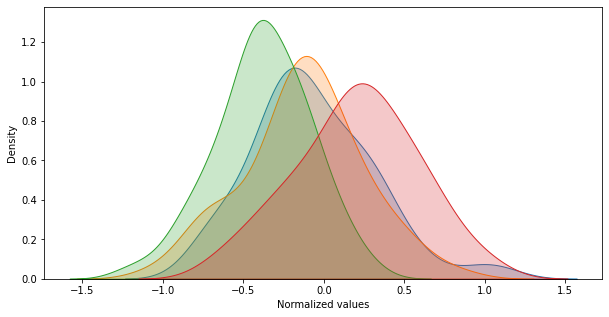

epoch 100 || lossD = 1.4254316091537476 | lossG = 0.9029125571250916


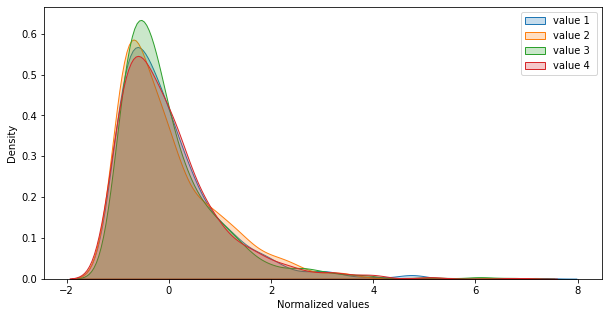

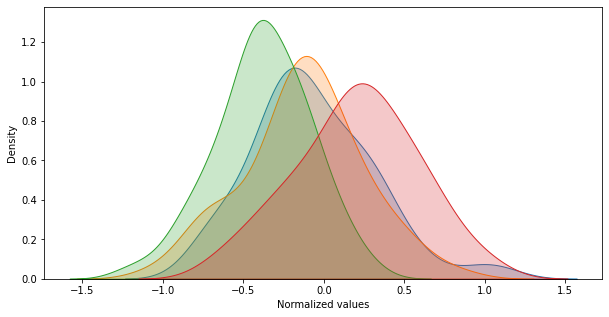

epoch 200 || lossD = 1.4274232387542725 | lossG = 0.9028010964393616


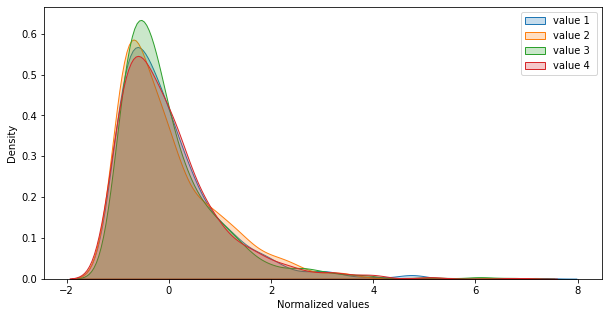

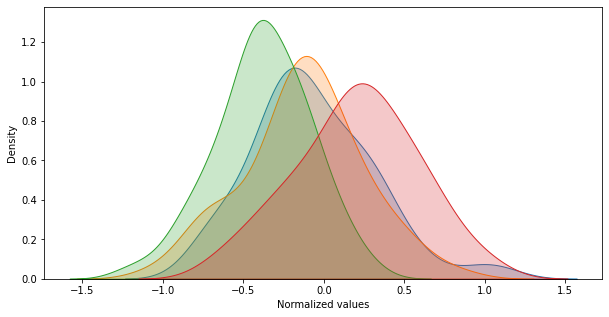

epoch 300 || lossD = 1.4260276556015015 | lossG = 0.902209997177124


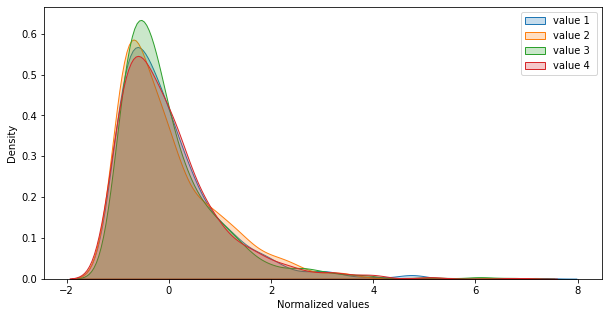

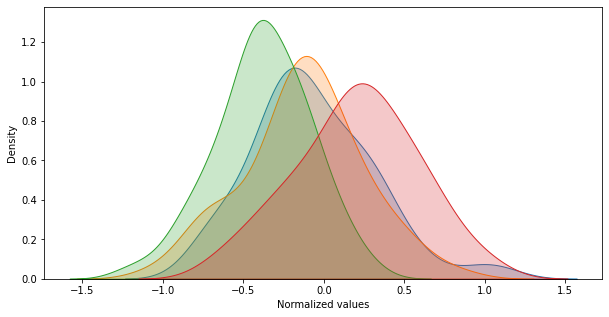

epoch 400 || lossD = 1.4242146015167236 | lossG = 0.9029214382171631


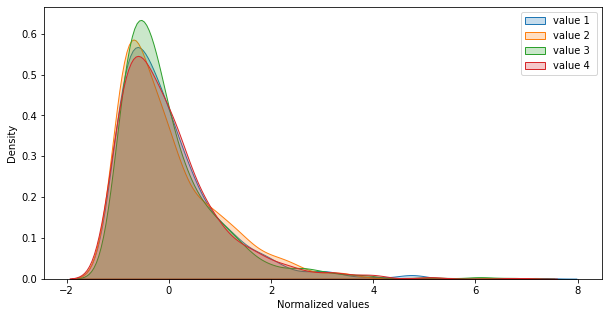

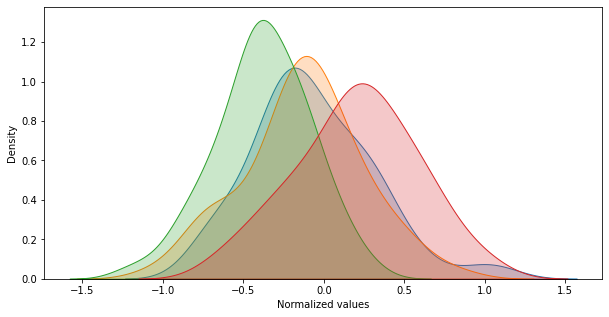

epoch 500 || lossD = 1.4232112169265747 | lossG = 0.9024380445480347


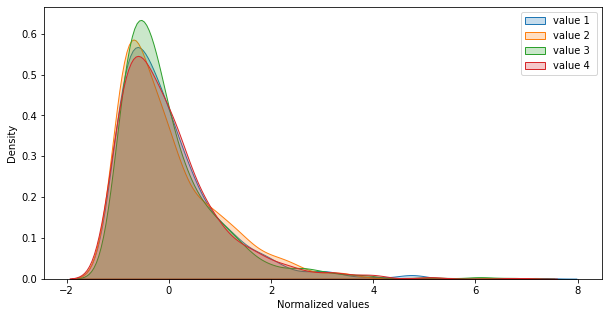

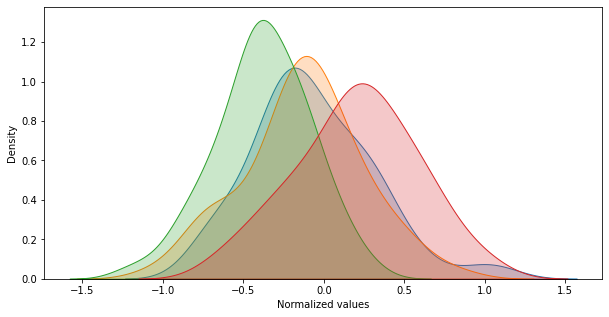

KeyboardInterrupt: 

In [53]:
D = Disciminator().to(device)
G = Generator().to(device)

for epoch in range(n_epochs):

    for i,data in enumerate(train_ds_loader, 0):

        # STEP 1 : Discriminator optimization step

        optimizerD.zero_grad()

        x_real, y_real = iter(train_ds_loader).next()
        x_real = x_real.float()
        D_x_real = D(x_real)
        lossD_real = criterion(D_x_real, torch.ones((x_real.shape[0],1)).to(device))

        z = torch.randn(batch_size, 100).to(device)
        x_gen = G(z).detach()
        D_x_gen = D(x_gen)
        lossD_fake = criterion(D_x_gen, torch.zeros((x_gen.shape[0],1)).to(device))

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        # STEP 2 : Discriminator optimization step

        optimizerG.zero_grad()

        z = torch.randn(batch_size, 100).to(device)
        x_gen = G(z)
        
        D_x_gen = D(x_gen)
        lossG = criterion(D_x_gen, torch.ones((x_gen.shape[0],1)).to(device))

        lossG.backward()
        optimizerG.step()

    if (epoch+1)%500 == 0 or epoch==0:

        print("epoch {} || lossD = {} | lossG = {}".format(epoch+1, lossD.item(), lossG.item()))

        plt.figure(figsize=(10,5))
        for column in train_df_normalized.columns:
            sns.kdeplot(train_df_normalized[column], shade=True)
        plt.xlabel("Normalized values")
        plt.legend(labels=["value 1", "value 2 ", "value 3", "value 4"])
        plt.show()

        x_gen = G(fixed_noise)
        x_gen_df = pd.DataFrame(x_gen.cpu().detach().numpy())
        
        plt.figure(figsize=(10,5))
        for column in x_gen_df.columns:
            sns.kdeplot(x_gen_df[column], shade=True)
        plt.xlabel("Normalized values")
        plt.show()
    
    x_gen = G(fixed_noise)
    collect_x_gen.append(x_gen.detach().clone())

In [ ]:
x=0